## Imports and setup

In [ ]:
# Grab data from ACS with cenpy (don't need to run every time!)
# Variables:
#    - total population (B01003_001E)
#    - total white (B02008_001E)
#    - total black (B02009_001E)
#    - total asian (B02011_001E)
#    - total hispanic (B03001_003E)
#    - median household income (B19013_001E)
#    - median house price (B25077_001E)
#    - total tenure (B25032_001E)
#    - total owner occupied (B25032_002E)
#    - total renter occupied (B25032_007E)
#    - median contract rent (B25064_001E)
#    - total in labor force (B23025_002E)
#    - total employed (civilian) (B23025_004E)
#    - total unemployed (civilian) (B23025_005E)

countydata = gpd.GeoDataFrame()

states = pd.read_csv('../utils/states.csv')['State'].values
for state in tqdm(states):
    countydata = countydata.append(acs.from_state(state=state, variables=variables, level='county'))

countydata.to_csv('../data/ACS_countydata.csv')

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import stan_jupyter as stan
from scipy.linalg import norm

from tqdm import tqdm
from cenpy.products import ACS
from spint.gravity import Gravity, Attraction, Production

acs = ACS()
LA_FIPS = '06037'  # LA County FIPS code
variables = ['B01003_001E', 'B02008_001E', 'B02009_001E', 'B02011_001E', 'B03001_003E', \
    'B19013_001E', 'B25077_001E', 'B25032_001E', 'B25032_002E', 'B25032_007E', \
    'B25064_001E', 'B23025_002E', 'B23025_004E', 'B23025_005E']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Load data

In [2]:
# Flows
inflows_raw = pd.read_csv('../data/LACounty_ACS_2014_2018_All_IN.csv', usecols=['State/County FIPS', 'Total', 'Margin of Error (+/-)']).replace("'", "", regex=True)
outflows_raw = pd.read_csv('../data/LACounty_ACS_2014_2018_All_OUT.csv', usecols=['State/County FIPS', 'Total', 'Margin of Error (+/-)']).replace("'", "", regex=True)
outflows_raw.rename(columns={'State/County FIPS' : 'destFIPS', 'Total' : 'total_out', 'Margin of Error (+/-)' : 'outMOE'}, inplace=True)
inflows_raw.rename(columns={'State/County FIPS' : 'originFIPS', 'Total' : 'total_in', 'Margin of Error (+/-)' : 'inMOE'}, inplace=True)

In [3]:
# County-level demographic data (and convert covariate columns)
countydata = gpd.read_file('../data/ACS_countydata.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO").replace('', 0)
for var in variables:
    countydata[var] = countydata[var].astype(float)

In [4]:
# Ping ACS for data for LA county
la_data = acs.from_county("Los Angeles County, CA", variables=variables, level='county')

In [5]:
# Convert races, employment to percents
countydata['pctwhite'] = countydata['B02008_001E'] / countydata['B01003_001E']
countydata['pctblack'] = countydata['B02009_001E'] / countydata['B01003_001E']
countydata['pctasian'] = countydata['B02011_001E'] / countydata['B01003_001E']
countydata['pcthispa'] = countydata['B03001_003E'] / countydata['B01003_001E']
countydata['pctemplo'] = countydata['B23025_004E'] / countydata['B23025_002E']
countydata['pctunemp'] = countydata['B23025_005E'] / countydata['B23025_002E']
countydata['pctowner'] = countydata['B25032_002E'] / countydata['B25032_001E']
countydata['pctrentr'] = countydata['B25032_007E'] / countydata['B25032_001E']

la_data['pctwhite'] = la_data['B02008_001E'] / la_data['B01003_001E']
la_data['pctblack'] = la_data['B02009_001E'] / la_data['B01003_001E']
la_data['pctasian'] = la_data['B02011_001E'] / la_data['B01003_001E']
la_data['pcthispa'] = la_data['B03001_003E'] / la_data['B01003_001E']
la_data['pctemplo'] = la_data['B23025_004E'] / la_data['B23025_002E']
la_data['pctunemp'] = la_data['B23025_005E'] / la_data['B23025_002E']
la_data['pctowner'] = la_data['B25032_002E'] / la_data['B25032_001E']
la_data['pctrentr'] = la_data['B25032_007E'] / la_data['B25032_001E']

In [120]:
data_noouts = data[data['total_out'] < 5000]

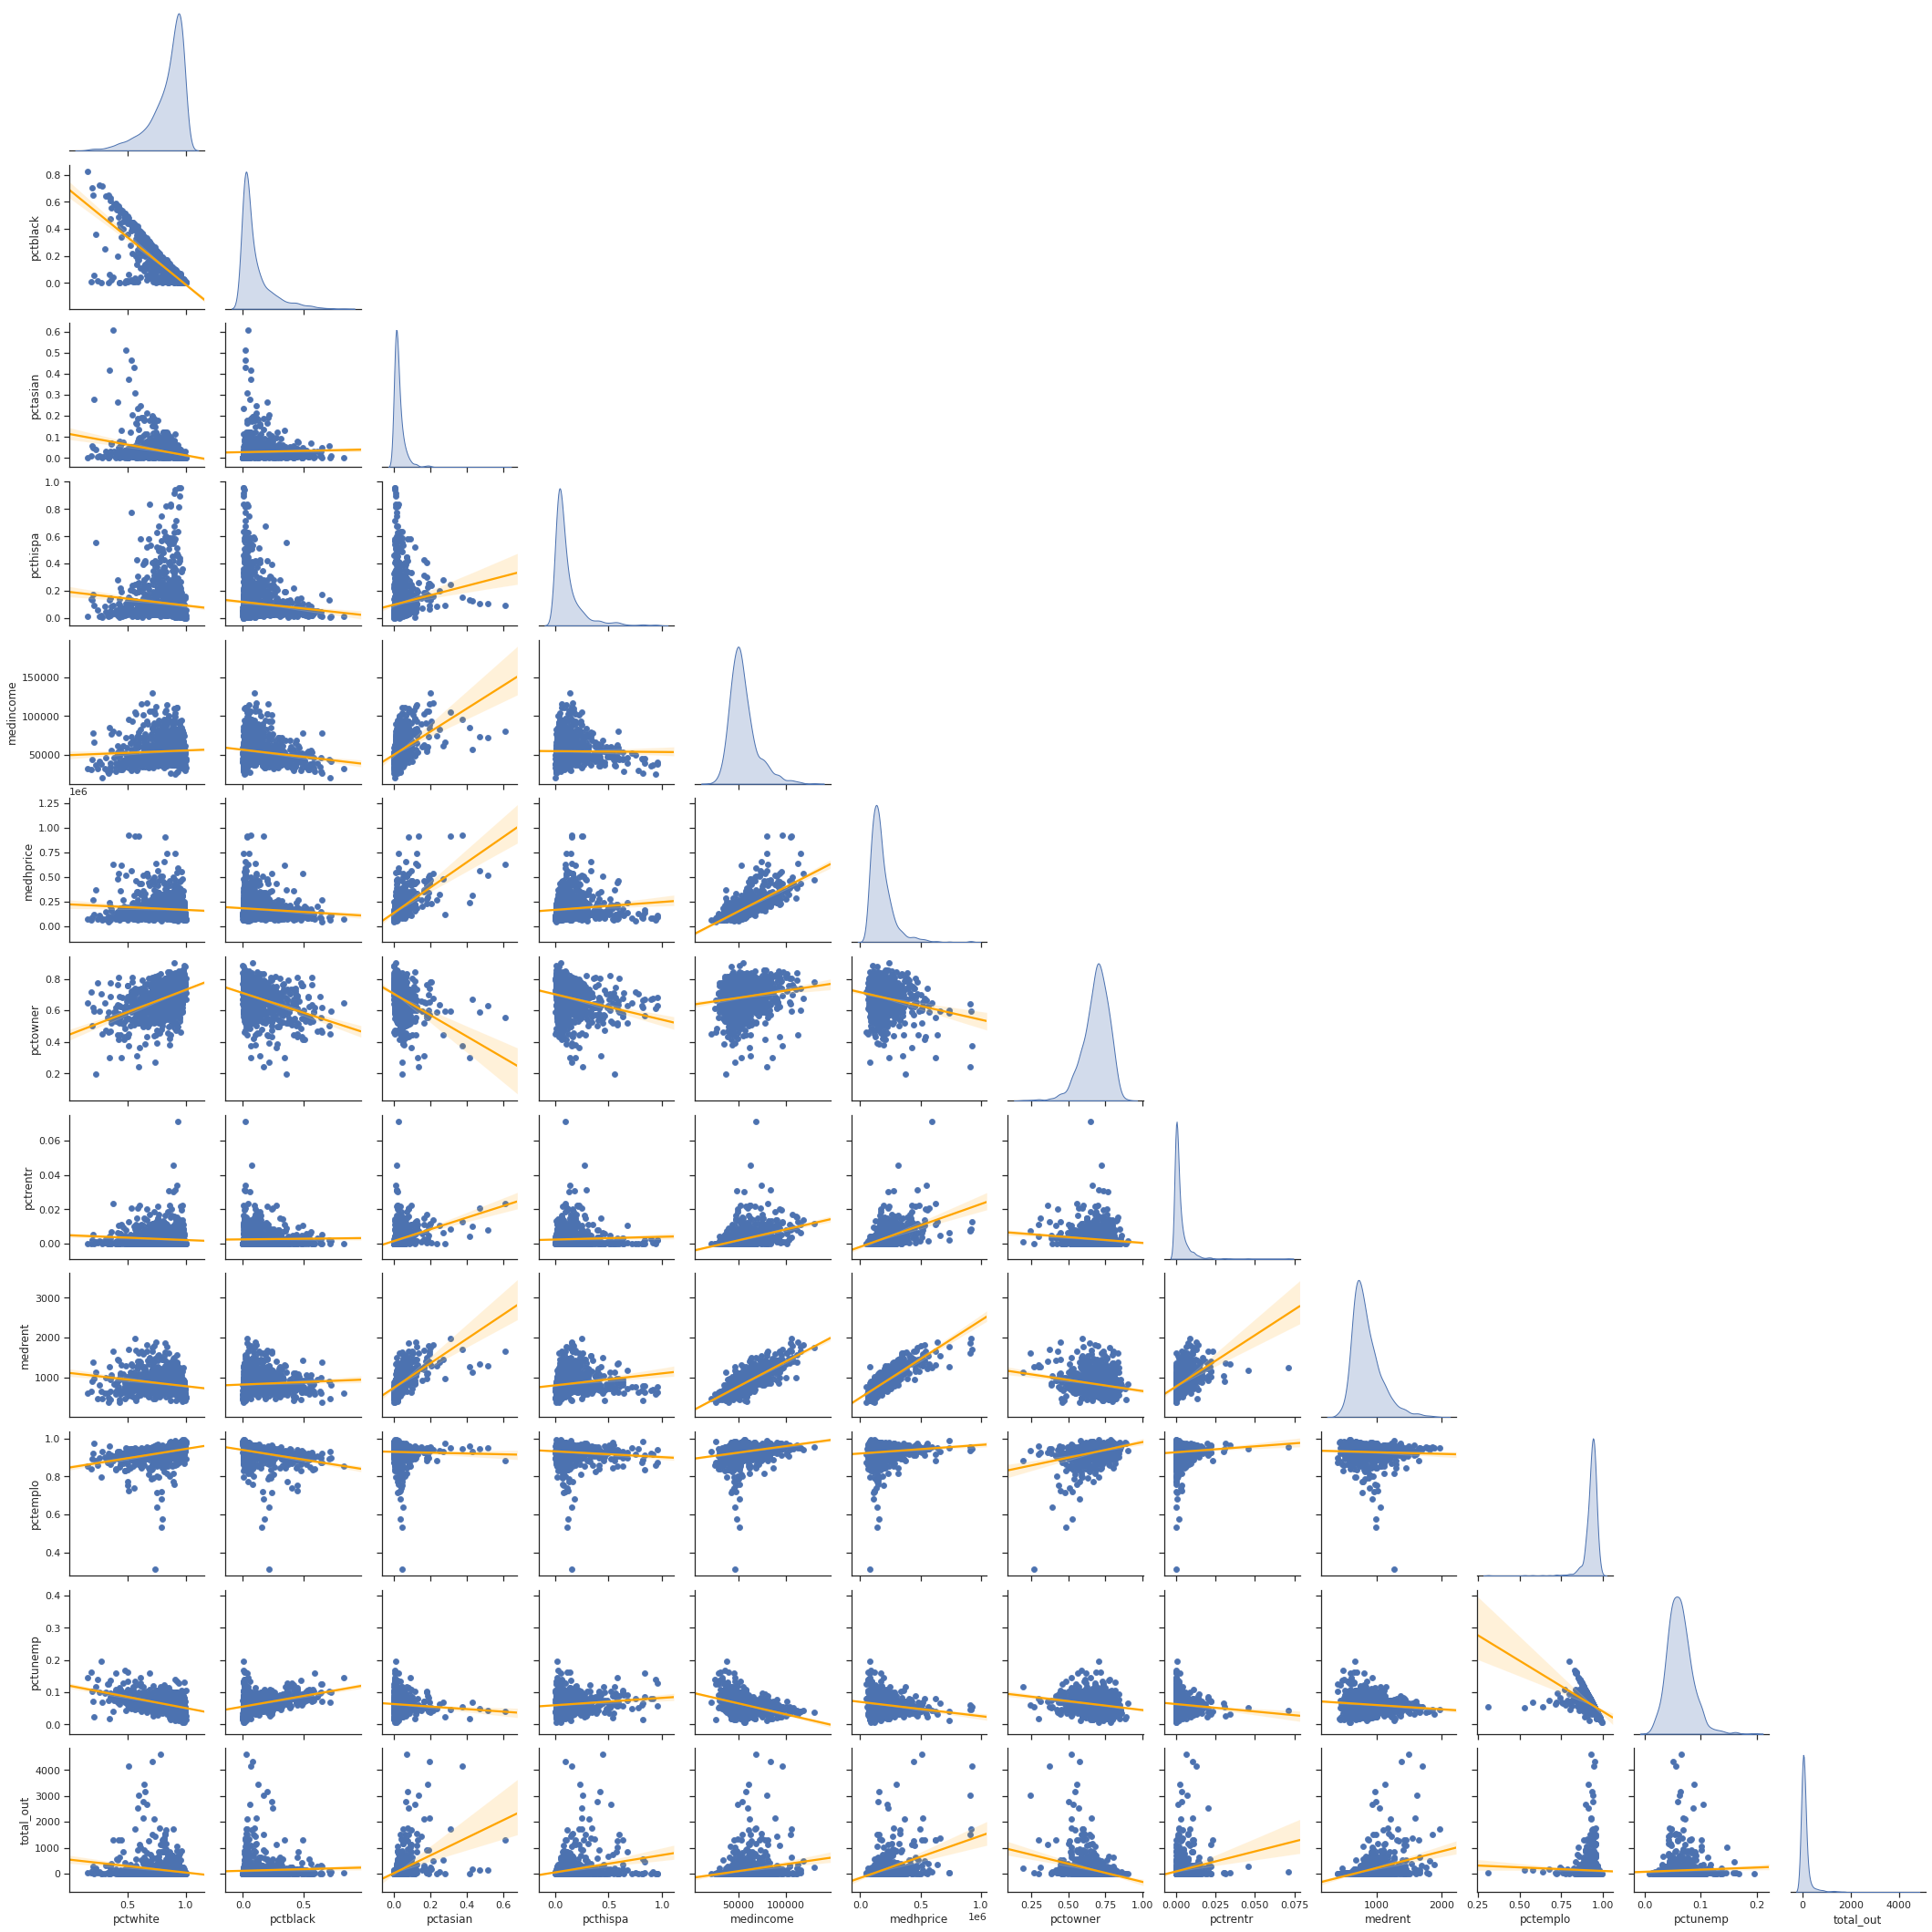

In [123]:
allvars = ['pctwhite', 'pctblack', 'pctasian', 'pcthispa', \
    'medincome', 'medhprice', 'pctowner', 'pctrentr', \
    'medrent', 'pctemplo', 'pctunemp']

sns.set_theme(style='ticks')
corrs = sns.pairplot(data_noouts[allvars + ['total_out']], diag_kind='kde', corner=True)
corrs.map_lower(sns.regplot, truncate=False, line_kws={"color": "orange"})
plt.savefig('../pics/scatterplot-matrix.png')

In [87]:
# Rename remaining columns and record plaintext variables
countydata.rename(columns={'B25064_001E' : 'medrent', 'B19013_001E' : 'medincome', 'B25077_001E' : 'medhprice'}, inplace=True)
plainvars = ['pctwhite', \
    'medincome', 'pctowner', \
    'pctemplo', 'pctunemp']
# Problems: medincome, medhprice, medrent: one or more arrays have missing or NaN
#           pctowner, pctrentr, pctemplo, pctunemp: gives NaN SE and tvalues in origin field

## Rearrage data to prep for analysis

In [88]:
# Merge all the data into one big dataframe to make it simpler
data = pd.merge(pd.merge(countydata, outflows_raw, how='inner', left_on='GEOID', right_on='destFIPS'), inflows_raw, how='inner', left_on='GEOID', right_on='originFIPS').set_crs(epsg=3395)
la_data.rename(columns={'B25064_001E' : 'medrent', 'B19013_001E' : 'medincome', 'B25077_001E' : 'medhprice'}, inplace=True)
la_covars = np.tile(la_data[plainvars].values, (data.shape[0], 1))  # repeat the data so that we account for the single location properly

In [89]:
# costs are all distances between LA and the out or in destination
coords = np.hstack((data.centroid.x.values.reshape(-1, 1), data.centroid.y.values.reshape(-1, 1)))
la_coords = np.array([la_data.centroid.x[0], la_data.centroid.y[0]])
cost = norm(la_coords - coords, axis=1)

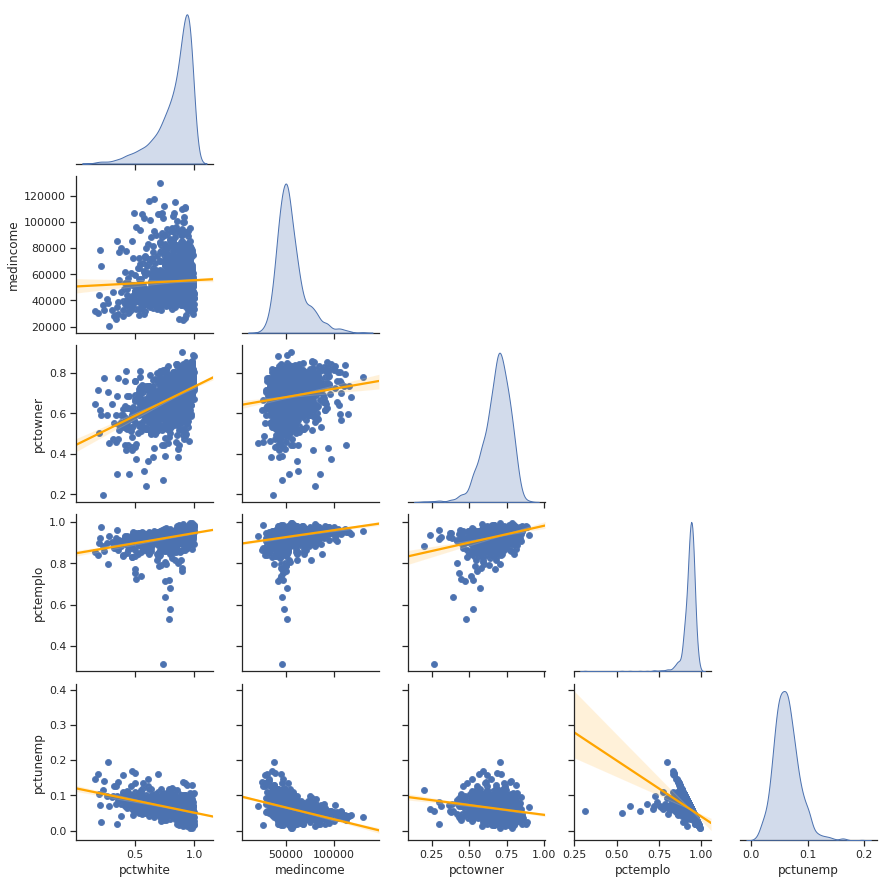

In [109]:
# Plot correlations to survey the data
sns.set_theme(style='ticks')
corrs = sns.pairplot(data[plainvars], diag_kind='kde', corner=True)
corrs.map_lower(sns.regplot, truncate=False, line_kws={"color": "orange"})

It looks like there's some collinearity between `medincome` and `medrent` as well as `medhprice` and `medrent`. Let's remove `medrent` from the data and see what happens.

## Calibrate model 

In [114]:
model = Gravity(flows=data['total_out'].values.reshape(-1, 1), o_vars=la_covars, d_vars=data[plainvars].values, cost=cost, cost_func='exp', constant=False)

In [ ]:
paramnames = [*[x + '_o' for x in plainvars], *[x + '_d' for x in plainvars], 'distance']
pd.DataFrame(data={'paramname' : paramnames, 'paramval' : model.params, 'SE' : model.std_err, 'tvalue' : model.tvalues, 'pvalue' : model.pvalues})  # origin attrs, dest attrs, distance

,paramname,paramval,SE,tvalue,pvalue
0,pctwhite_o,-1.729222e+02,8.526473e+04,-0.002028,0.998382
1,medincome_o,-5.415558e+00,NaN,NaN,NaN
2,pctowner_o,1.039773e+02,8.831203e+04,0.001177,0.999061
3,pctemplo_o,5.532436e+02,1.734524e+05,0.003190,0.997455
4,pctunemp_o,-2.028090e+01,1.683098e+04,-0.001205,0.999039
5,pctwhite_d,-1.016499e+00,1.029080e-02,-98.777462,0.000000
6,medincome_d,3.631804e+00,8.154375e-03,445.381014,0.000000
7,pctowner_d,-3.061936e+00,1.284926e-02,-238.296707,0.000000
8,pctemplo_d,2.214852e+00,4.712014e-02,47.004362,0.000000
9,pctunemp_d,1.990631e+00,6.951975e-03,286.340367,0.000000


In [84]:
model.SSI  # wow this is...truly terrible

0.3378916334626184

## Bayesian code -- RUNS OUT OF MEMORY
(just for kicks)

In [ ]:
gravity_code = """
data {
    int<lower=0> n;      // number of flows
    int<lower=1> k_d;    // number of variables at destinations
    int<lower=1> k_o;    // number of variables at origins
    int f[n];            // flows
    matrix[n, k_d] X_d;  // data at destinations
    matrix[n, k_o] X_o;  // data at origins
    vector[n] dist;      // distances for each flow
}

parameters {
    vector[k_o] beta_o;       // origin parameters
    vector[k_d] beta_d;       // destination parameters
    real<upper=0> beta_dist;  // distance decay parameter
    real alpha;               // intercept
}

transformed parameters {
    vector[n] mu = exp(alpha + log(X_o)*beta_o + log(X_d)*beta_d - beta_dist*log(dist));  // mean of flow process
}

model {
    f ~ poisson(mu);

    // priors -- uninformed for everything but beta_dist
    beta_o ~ normal(0, 5);
    beta_d ~ normal(0, 5);
    beta_dist ~ normal(0, 1);
    alpha ~ normal(0, 5);
}

generated quantities {

}
"""

In [ ]:
# RUNS OUT OF MEMORY
gravity_data = {
    "n" : data['total_out'].shape[0],
    "f" : data['total_out'].values,
    "k_d" : np.exp(la_covars).shape[1],
    "k_o" : np.exp(data[plainvars].values).shape[1],
    "X_d" : np.exp(la_covars),
    "X_o" : np.exp(data[plainvars].values),
    "dist" : cost
}

gravity_posterior = stan.build(gravity_code, data=gravity_data)
gravity_fit = gravity_posterior.sample(num_chains=3, num_warmup=9000, num_samples=1000, save_warmup=False)
gravity_results = gravity_fit.to_frame()

## Constrained models

In [ ]:
out_model = Production(flows=data['total_out'].values, origins=data['originFIPS'].values, d_vars=data[variables].values, cost=cost, cost_func='exp')
in_model = Attraction(flows=data['total_in'].values, destinations=data['destFIPS'].values, o_vars=data[variables].values, cost=cost, cost_func='exp')